Chào mừng bạn đến với lab đầu tiên của mô-đun "Tối ưu hóa trong mạng nơ-ron sâu".

Việc huấn luyện mạng nơ-ron của bạn yêu cầu chỉ định một giá trị khởi tạo của các trọng số. Một phương pháp khởi tạo được lựa chọn tốt sẽ giúp ích cho việc học. Bạn có thể đã làm theo hướng dẫn của chúng tôi để khởi tạo trọng số và cho đến nay nó vẫn hoạt động tốt. Nhưng làm thế nào để chọn khởi tạo cho một mạng nơ-ron mới? Trong notebook này, bạn sẽ thấy các cách khởi tạo khác nhau dẫn đến các kết quả khác nhau.

Khởi tạo được chọn tốt có thể:
- Tăng tốc độ hội tụ của gradient descent
- Tăng tỷ lệ hội tụ gradient descent thành lỗi huấn luyện thấp hơn (và tổng quát hóa)

Để bắt đầu, hãy chạy cell sau để tải các thư viện và tập dữ liệu phẳng mà bạn sẽ cố gắng phân loại.

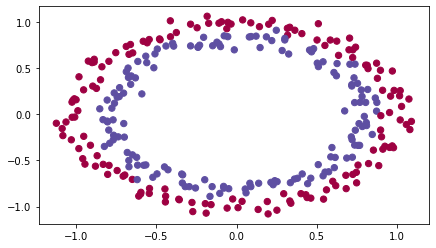

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from init_utils import sigmoid, relu, compute_loss, forward_propagation, backward_propagation
from init_utils import update_parameters, predict, load_dataset, plot_decision_boundary, predict_dec

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # đặt kích thước mặc định của biểu đồ
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

Bạn muốn có một bộ phân loại để tách các chấm màu xanh lục khỏi các chấm màu đỏ.

## 1 - Mô hình Mạng nơ-ron 

Bạn sẽ sử dụng mạng nơ-ron 3 lớp (đã triển khai cho bạn). Dưới đây là các phương pháp khởi tạo mà bạn sẽ thử nghiệm:
- *Zeros initialization ( Khởi tạo bằng 0)* --  thiết lập `initialization = "zeros"` trong đối số đầu vào.
- *Random initialization (Khởi tạo ngẫu nhiên)* -- thiết lập `initialization = "random"` trong đối số đầu vào. Điều này khởi tạo các trọng số thành các giá trị ngẫu nhiên lớn. 
- *He initialization (Khởi tạo He)* -- thiết lập `initialization = "he"` trong đối số đầu vào. Điều này khởi tạo các trọng số thành các giá trị ngẫu nhiên được chia tỷ lệ theo một bài báo của He và cộng sự, 2015.

**Hướng dẫn**: Vui lòng đọc nhanh đoạn code bên dưới và chạy nó. Trong phần tiếp theo, bạn sẽ thực hiện 3 phương thức khởi tạo mà `model()` này gọi.

In [2]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Triển khai mạng nơ-ron 3 lớp: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Đối số:
    X -- dữ liệu đầu vào có shape (2, số ví dụ)
    Y -- vectơ true "label" (0 cho chấm đỏ; 1 cho chấm xanh), có shape (1, số ví dụ)
    learning_rate -- tốc độ học cho gradient descent 
    num_iterations -- số lần lặp để chạy gradient descent
    print_cost -- nếu True, in ra cost sau mỗi 100 lần lặp
    initialization -- gắn cờ để chọn sử dụng khởi tạo nào ("zeros","random" or "he")
    
    Trả về:
    parameters -- các tham số được mô hình tìm hiểu
    """
        
    grads = {}
    costs = [] # theo dõi loss
    m = X.shape[1] # số ví dụ
    layers_dims = [X.shape[0], 10, 5, 1]
    
    # Khởi tạo dictionary parameters.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Vòng lặp (gradient descent)

    for i in range(0, num_iterations):

        # Lan truyền xuôi: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss
        cost = compute_loss(a3, Y)

        # Lan truyền ngược.
        grads = backward_propagation(X, Y, cache)
        
        # Cập nhật tham số.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # In ra loss sau mỗi 1000 lần lặp
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # vẽ biểu đồ của loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 2 - Zero initialization (Khởi tạo bằng không)

Có 2 loại tham số để khởi tạo trong mạng nơ-ron:
- ma trận trọng số $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- vectơ bias $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

**Task 1**: Triển khai hàm sau để khởi tạo tất cả các tham số thành 0. Sau đó, bạn sẽ thấy rằng điều này không hoạt động tốt vì nó không thể "phá vỡ đối xứng", nhưng hãy thử nó và xem điều gì sẽ xảy ra. Sử dụng np.zeros((.., ..)) với các shape chính xác. 

In [6]:
def initialize_parameters_zeros(layers_dims):
    """
    Đối số:
    layer_dims -- mảng python (list) chứa kích thước của mỗi lớp.
    
    Trả về:
    parameters -- dictionary của python chứa các tham số "W1", "b1", ..., "WL", "bL":
                    W1 -- ma trận trọng số có shape (layers_dims[1], layers_dims[0])
                    b1 -- vectơ bias có shape (layers_dims[1], 1)
                    ...
                    WL -- ma trận trọng số có shape (layers_dims[L], layers_dims[L-1])
                    bL -- vectơ bias có shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims)            # số lớp trong mạng
    
    for l in range(1, L):
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
        parameters['W' + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### KẾT THÚC CODE Ở ĐÂY ###
    return parameters

In [7]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


**Kỳ vọng đầu ra**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 0.  0.  0.]
 [ 0.  0.  0.]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[ 0.  0.]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Chạy code sau để huấn luyện mô hình của bạn trên 15.000 lần lặp bằng cách sử dụng zero initialization.

Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599455
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


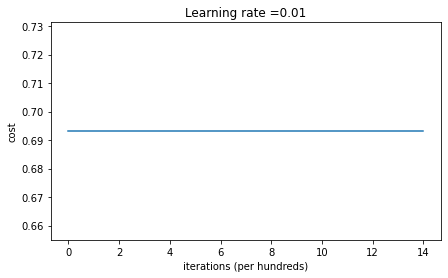

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [8]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Hiệu suất thực sự tồi tệ, cost không thực sự giảm và thuật toán thực hiện không tốt hơn so với đoán ngẫu nhiên. Tại sao? Hãy xem chi tiết các dự đoán và ranh giới quyết định:

In [9]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


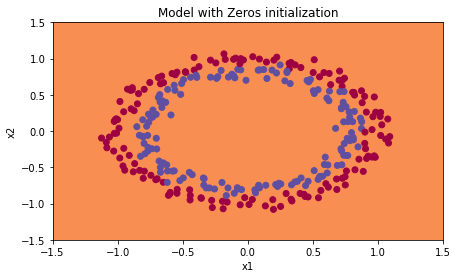

In [10]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

Mô hình dự đoán 0 cho mọi ví dụ.

Nhìn chung, việc khởi tạo tất cả các trọng số bằng 0 dẫn đến việc mạng không thể phá vỡ tính đối xứng. Điều này có nghĩa là mọi nơ-ron trong mỗi lớp sẽ học giống nhau và bạn cũng có thể đang huấn luyện một mạng nơ-ron với $ n ^ {[l]} = 1 $ cho mọi lớp và mạng này không mạnh hơn mạng phân loại tuyến tính, chẳng hạn như hồi quy logistic. 

<font color='blue'>
**Bạn cần nhớ**:
- Các trọng số $W^{[l]}$ nên được khởi tạo ngẫu nhiên để phá vỡ tính đối xứng. 
- Tuy nhiên, có thể khởi tạo các bias $b^{[l]}$ thành 0. Tính đối xứng vẫn bị phá vỡ miễn là $W^{[l]}$ được khởi tạo ngẫu nhiên.  


## 3 - Random initialization (Khởi tạo ngẫu nhiên)

Để phá vỡ tính đối xứng, hãy khởi tạo các trọng số một cách ngẫu nhiên. Sau khi khởi tạo ngẫu nhiên, mỗi nơ-ron sau đó có thể tiếp tục học một hàm khác nhau của các đầu vào. Trong nhiệm vụ này, bạn sẽ thấy những gì sẽ xảy ra nếu các trọng số được khởi tạo một cách ngẫu nhiên, nhưng với các giá trị rất lớn.


**Task 2**: Triển khai hàm sau để khởi tạo trọng số của bạn thành các giá trị ngẫu nhiên lớn (được chia tỷ lệ bằng \*10) và bias thành 0. Sử dụng `np.random.randn(..,..)*10` cho trọng số và `np.zeros((..,..))`cho bias. Chúng ta đang sử dụng `np.random.seed(..)` cố định để đảm bảo trọng số "ngẫu nhiên" của bạn khớp với trọng số của chúng tôi, vì vậy đừng lo lắng nếu nhiều lần chạy code của bạn luôn cho các giá trị khởi tạo tương tự cho các tham số. 

In [13]:
def initialize_parameters_random(layers_dims):
    """
    Đối số:
    layer_dims -- mảng python (list) chứa kích thước của mỗi lớp.
    
    Trả về:
    parameters -- dictionary của python chứa các tham số "W1", "b1", ..., "WL", "bL":
                    W1 -- ma trận trọng số có shape (layers_dims[1], layers_dims[0])
                    b1 -- vectơ bias có shape (layers_dims[1], 1)
                    ...
                    WL -- ma trận trọng số có shape (layers_dims[L], layers_dims[L-1])
                    bL -- vectơ bias có shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # seed này đảm bảo các số là ngẫu nhiên
    parameters = {}
    L = len(layers_dims)            # số nguyên thể hiện số lớp
    
    for l in range(1, L):
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### KẾT THÚC CODE Ở ĐÂY ###

    return parameters

In [14]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


**Kỳ vọng đầu ra**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[-0.82741481 -6.27000677]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Chạy code sau để huấn luyện mô hình của bạn trên 15.000 lần lặp bằng cách sử dụng random initialization.

C:\Users\Nguyễn Hoài Nam\OneDrive\Machine Learning\Lab_Exercise_MLP303x_Regression\Lab 5\init_utils.py:145: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\Nguyễn Hoài Nam\OneDrive\Machine Learning\Lab_Exercise_MLP303x_Regression\Lab 5\init_utils.py:145: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 0: inf
Cost after iteration 1000: 0.6243339944795463
Cost after iteration 2000: 0.5983698376976234
Cost after iteration 3000: 0.5640713641303857
Cost after iteration 4000: 0.5502225777263651
Cost after iteration 5000: 0.5445189912897229
Cost after iteration 6000: 0.5374939942050982
Cost after iteration 7000: 0.47927872911735586
Cost after iteration 8000: 0.39787508336662053
Cost after iteration 9000: 0.3934925383461005
Cost after iteration 10000: 0.3920373161708829
Cost after iteration 11000: 0.38930570830972355
Cost after iteration 12000: 0.3861562072516527
Cost after iteration 13000: 0.38499595295812233
Cost after iteration 14000: 0.38280923039736164


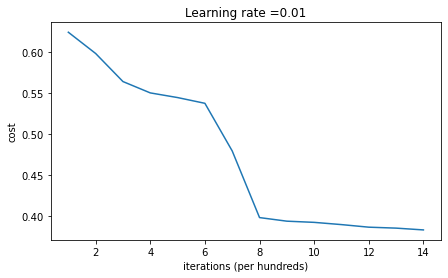

On the train set:
Accuracy: 0.83
On the test set:
Accuracy: 0.86


In [15]:
parameters = model(train_X, train_Y, initialization = "random")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Nếu bạn thấy "inf" là cost sau lần lặp 0 thì điều này là do làm tròn số; một triển khai phức tạp hơn về số lượng sẽ khắc phục điều này. Nhưng điều này không đáng lo ngại đối với mục tiêu của chúng ta.

Dù sao, có vẻ như bạn đã phá vỡ đối xứng và điều này mang lại kết quả tốt hơn so với trước đây. Mô hình không còn xuất ra tất cả các số 0 nữa. 

In [16]:
print (predictions_train)
print (predictions_test)

[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


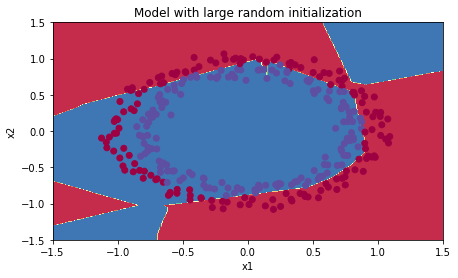

In [17]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

**Quan sát**:
- Cost bắt đầu rất cao. Điều này do với các trọng số có giá trị ngẫu nhiên lớn, lần kích hoạt cuối cùng (sigmoid) cho ra kết quả rất gần với 0 hoặc 1 đối với một số ví dụ, và khi ví dụ đó sai, nó sẽ bị mất mát rất cao. Thật vậy, khi $ \ log (a ^ {[3]}) = \ log (0) $, mất mát (loss) là vô cực.
- Khởi tạo kém có thể dẫn đến việc các gradient biến mất/bùng nổ, điều này cũng làm chậm thuật toán tối ưu hóa.
- Nếu bạn huấn luyện mạng này lâu hơn sẽ thấy kết quả tốt hơn, nhưng việc khởi tạo với số ngẫu nhiên quá lớn sẽ làm chậm việc tối ưu hóa.

<font color='blue'>
**Tóm lại**:
- Việc khởi tạo các trọng số thành các giá trị ngẫu nhiên rất lớn không hoạt động tốt.
- Hy vọng khởi tạo với các giá trị ngẫu nhiên nhỏ sẽ tốt hơn. Điều quan trọng là: các giá trị ngẫu nhiên này phải nhỏ đến mức nào? Hãy cùng tìm hiểu trong phần tiếp theo! 

## 4 - He initialization (Khởi tạo He)

Cuối cùng, hãy thử "He Initialization"; nó được đặt tên cho tác giả đầu tiên của He và cộng sự, 2015. (Nếu bạn đã nghe nói về "Khởi tạo Xavier", điều này cũng tương tự ngoại trừ việc khởi tạo Xavier sử dụng hệ số tỷ lệ cho các trọng số $ W ^ {[l]} $ của `sqrt(1./layers_dims[l-1])` nơi khởi tạo He sẽ sử dụng `sqrt(2./layers_dims[l-1])`.)

**Task 3**: Triển khai hàm sau để khởi tạo các tham số của bạn với He initialization.

**Gợi ý**: Hàm này tương tự như hàm `initialize_parameters_random(...)` trước đó. Sự khác biệt duy nhất là thay vì nhân `np.random.randn(.., ..)' với 10, bạn sẽ nhân nó với $\sqrt{\frac{2}{\text {chiều của lớp trước}}}$, đó là những gì He initialization đề xuất cho các lớp có kích hoạt ReLU. 

In [25]:
def initialize_parameters_he(layers_dims):
    """
    Đối số:
    layer_dims -- mảng python (list) chứa kích thước của mỗi lớp.
    
    Trả về:
    parameters -- dictionary của python chứa các tham số "W1", "b1", ..., "WL", "bL":
                    W1 -- ma trận trọng số có shape (layers_dims[1], layers_dims[0])
                    b1 -- vectơ bias có shape (layers_dims[1], 1)
                    ...
                    WL -- ma trận trọng số có shape (layers_dims[L], layers_dims[L-1])
                    bL -- vectơ bias có shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # số nguyên thể hiện số lớp
     
    for l in range(1, L + 1):
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt((2./layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### KẾT THÚC CODE Ở ĐÂY ###
        
    return parameters

In [26]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


**Kỳ vọng đầu ra**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Chạy code sau để huấn luyện mô hình của bạn trên 15.000 lần lặp bằng cách sử dụng He initialization.

Cost after iteration 0: 0.8830537463419761
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893807
Cost after iteration 4000: 0.6082958970572938
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.4138645817071795
Cost after iteration 7000: 0.31178034648444414
Cost after iteration 8000: 0.23696215330322562
Cost after iteration 9000: 0.18597287209206836
Cost after iteration 10000: 0.15015556280371808
Cost after iteration 11000: 0.12325079292273551
Cost after iteration 12000: 0.09917746546525934
Cost after iteration 13000: 0.08457055954024277
Cost after iteration 14000: 0.07357895962677363


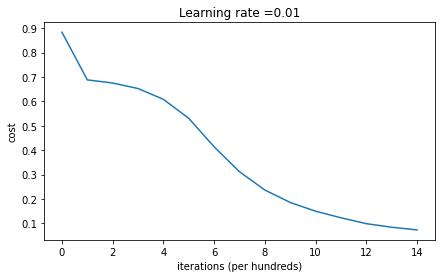

On the train set:
Accuracy: 0.9933333333333333
On the test set:
Accuracy: 0.96


In [27]:
parameters = model(train_X, train_Y, initialization = "he")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

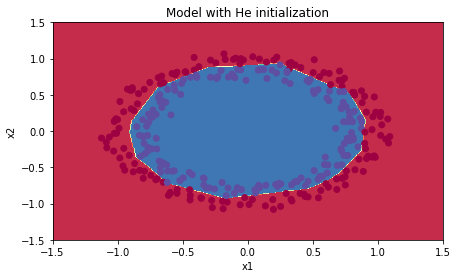

In [29]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0])

**Quan sát**:
- Mô hình có He initialization phân tách các chấm màu xanh và màu đỏ rất tốt trong số ít lần lặp lại. 

## 5 - Tổng kết

Bạn đã thấy 3 kiểu khởi tạo khác nhau. Đối với cùng một số lần lặp lại và cùng một siêu tham số (hyperparameter), phép so sánh là:

<table> 
    <tr>
        <td>
        **Model**
        </td>
        <td>
        **Train accuracy**
        </td>
        <td>
        **Problem/Comment**
        </td>

    </tr>
        <td>
        3-layer NN with zeros initialization
        </td>
        <td>
        50%
        </td>
        <td>
        fails to break symmetry
        </td>
    <tr>
        <td>
        3-layer NN with large random initialization
        </td>
        <td>
        83%
        </td>
        <td>
        too large weights 
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with He initialization
        </td>
        <td>
        99%
        </td>
        <td>
        recommended method
        </td>
    </tr>
</table> 

<font color='blue'>
    
**Những điều bạn nên nhớ từ notebook này**:
    
- Khởi tạo khác nhau dẫn đến kết quả khác nhau
- Random initialization (Khởi tạo ngẫu nhiên) được sử dụng để phá vỡ đối xứng và đảm bảo các đơn vị ẩn khác nhau có thể học những thứ khác nhau
- Không khởi tạo các giá trị quá lớn
- He initialization (Khởi tạo He) hoạt động tốt với các mạng có kích hoạt ReLU. 